#<center>Single Image Haze Removal Using Dark Channel Prior</center>

## **Resumé**
Le but de ce projet est d’éliminer le brouillard(Haze) à partir d'une estimation d'une Dark channel. On constate grâce à des statistiques faites sur des images sans haze que la plupart des régions locales dans une image, sans prendre en compte les régions du ciel, ont des faibles intensités dans au moins une des canaux RGB. Par contre, la lumière aérienne affecte ces régions et augmente leur intensité. Par conséquent, ceci nous aide à détecter l’effet du haze et calculer ses parametres et par suite l’éliminer.
En se basant sur l'article [Single Image Haze Removal Using Dark Channel Prior](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiGk5r-lpD0AhXKx4UKHQOMDIwQFnoECAQQAQ&url=http%3A%2F%2Fkaiminghe.com%2Fpublications%2Fcvpr09.pdf&usg=AOvVaw1qc5THLNa5hLIJu0TuychE) on va implementer dans ce projet cet methode tout en testant les effets des parametres sur le resultat. 



## Import needed libraries and data

In [1]:
!wget http://kaiminghe.com/cvpr09/forest/forest1.jpg
!wget http://kaiminghe.com/cvpr09/tiananmen/tiananmen1.png
!wget http://kaiminghe.com/cvpr09/mountain/mountain.png
!wget http://kaiminghe.com/cvpr09/toys/toys.jpg
!wget http://kaiminghe.com/cvpr09/flag/flag.jpg
!wget http://kaiminghe.com/cvpr09/beijing1/IMG_8766.jpg


--2021-11-15 19:15:14--  http://kaiminghe.com/cvpr09/forest/forest1.jpg
Resolving kaiminghe.com (kaiminghe.com)... 184.168.224.173
Connecting to kaiminghe.com (kaiminghe.com)|184.168.224.173|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 567344 (554K) [image/jpeg]
Saving to: ‘forest1.jpg’

forest1.jpg         100%[===================>] 554.05K  1.88MB/s    in 0.3s    

2021-11-15 19:15:15 (1.88 MB/s) - ‘forest1.jpg’ saved [567344/567344]

--2021-11-15 19:15:15--  http://kaiminghe.com/cvpr09/tiananmen/tiananmen1.png
Resolving kaiminghe.com (kaiminghe.com)... 184.168.224.173
Connecting to kaiminghe.com (kaiminghe.com)|184.168.224.173|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 354406 (346K) [image/png]
Saving to: ‘tiananmen1.png’

tiananmen1.png      100%[===================>] 346.10K  1.19MB/s    in 0.3s    

2021-11-15 19:15:15 (1.19 MB/s) - ‘tiananmen1.png’ saved [354406/354406]

--2021-11-15 19:15:16--  http://kaiminghe.com/cvpr0

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import math
import sys
import cv2
import scipy as sp
import scipy.ndimage
from cv2.ximgproc import guidedFilter
from io import BytesIO
from PIL import Image

## **Introduction**

Le brouillard dans une scène affecte l'intensité de la lumière reçu par un camera, et donc l'image va perdre son contraste et ses couleurs. A partir de ce problème, plusieurs ont essayés de le résoudre en utilisant différentes méthodes pour obtenir une image claire dont les couleurs sont vraies, cela est très important pour les utiliser dans d'autres applications de vision par ordinateur qui suppose que l'image entré représente les intensités de scène est non biaisé.

## **Modelisation d'une image avec Haze**

Pour bien etudier l'effet du haze dans une scène, on va falloir trouver une 
équation qui modélise l'image avec haze dont on pourra l'utiliser pour pouvoir éliminer le biais du brouillard. Les chercheurs ont pu trouver le modèle ci-dessous: 

\begin{equation}
\boxed{I(x) = J(x)t(x) + A(1-t(x))}
\end{equation}

$I(x)$ :  observés qu'on veut supprimer le Haze de.

$J(x)$ : les intensites du scene sans haze.

$t(x)$ : la transmission qui décrit la quantitée de la lumière qu'arrive au caméra.

$A$    : c'est l'intensité de la lumière atmosphérique.

$J(x)t(x)$ : Directed attenuation

$A(1-t(x))$ : Airlight

A l'aide de ce modele, on pourra, en calculant $t(x)$ et $A$, obtenir $J(x)$ et donc une image sans Haze.

In [3]:
test_im_1="forest1.jpg"

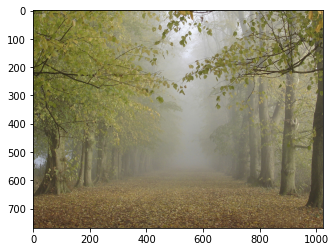

In [4]:
im = Image.open(test_im_1)
plt.imshow(im)

## **Dark Channel Prior**




Dans cet article, le chercheur suppose en se basant sur des statistiques faites sur des images d'extérieurs sans Haze, qu'au moins un canal de couleur aille un faible intensité sur un patch locale. Par contre, cette supposition ne marche pas sur les patchs de ciel car le couleur du ciel est quasiment la même que le Haze. A partir de ca, on va pouvoir annuler l'intensite minimale dans un patch local (Dark channel) dans l'image $J$.

La formule du dark channel de l'image $J$ est donc:
\begin{equation}
\boxed{J^{dark}(x) = \min\limits_{c \in \{r,g,b\}}(\min\limits_{y \in \Omega(x)}(J^c(y))) \approx 0}
\end{equation}

$J^c(y)$ est le couleur du canal $c$ et $\Omega(x)$ est un patch local.

$J^{dark}$ est à peu près null en se basant sur la supposition declarée avant. 

In [5]:
# Creates the shape of the kernel
def darkChannel(img, size=(7,7)):
  """
    Return the dark channel of the image img by applying an erosion of each channel
    using the kernel of size which is by default (7,7) and then choose the minimum 
    intensity among those 3 channels.
  """
  shape = cv2.MORPH_RECT
  kernel = cv2.getStructuringElement(shape, size)
  # Applies the minimum filter with kernel NxN
  dark_channel = cv2.erode(matrice_image, kernel)
  return np.amin(dark_channel,axis=2)

**Test the function**

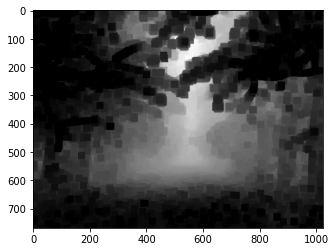

Percentage of dark pixels 57.399495442708336


In [6]:
matrice_image=np.asarray(im)
dark_channel = darkChannel(matrice_image,(25,25))
plt.imshow(dark_channel,cmap='gray')  # dark channel
plt.show()

dark_pixels = 100*dark_channel[dark_channel<40].shape[0]/(dark_channel.shape[0]*dark_channel.shape[1])
print("Percentage of dark pixels {}".format(dark_pixels))

## **Atmospheric light**


<p>
La lumière atmosphérique est définie comme etant la luminosité d'une scène à l'infini, qui est un paramètre important pour la restauration d'image basée sur le modèle de diffusion atmosphérique physique. L'image restaurée est plus sombre si la lumière atmosphérique globale estimée est plus forte qu'elle ne devrait l'être, et vice versa. <br> </p>
<p>
Dans la plupart des méthodes précédentes pour une seule image, la lumière atmosphérique A est estimée à partir du pixel dont l’intensité est la plus élevé. Mais le problème de cette approximation est que ce pixel peut appartenir à un objet dont la couleur est blanche c.à.d. n’a aucune relation avec la lumière atmosphérique. Par exemple, une voiture blanche ou un immeuble blanc. <br> 
</p>
<p>
Pour éviter ce problème, on n’extraira pas la valeur de la lumière atmosphérique de l’image directement, mais par contre, on travaillera sur le dark channel déjà calculer. En effet, comme indique précédemment, le dark channel de l’image fait une bonne approximation de la densité du haze de l’image et cela améliorera le résultat de l’approximation de la lumière atmosphérique. <br>
</p>
<p>
Pour appliquer cette idée en prendra les p% des pixels les plus brillant du dark channel. Puis on a 2 choix pour calculer l’approximation. La première est de prendre, parmi les pixels choisit, les pixels avec la plus grande intensité dans l’image initial I comme étant l’approximation de la lumière atmosphérique. Ou de prendre la moyenne de ces pixels dans l’image initiale I. <br> </p>
<p>
Cette simple idée basée sur l’utilisation du dark channel pour faire l’approximation de la lumière atmosphérique donne des résultats plus robustes que celle de la méthode qui choisit le pixel le plus claire de l’image de départ.
</p>


In [7]:
def get_Atmospheric_light(img, dark_channel, perc=0.1, method='Mean'):
  """
  This function return this atmospheric ligh of dark channel 
  and the indices of the perc(by default 0.1%) % brightest pixels
  Variables:
  img: the image we want to get the atmospheric ligh from
  perc: the percentage of the brithest pixels we want to work on
  method: the methode used to calculate the atmospheric light(
    Mean: average the brightest pixels
    Max: return the Maximum intensity of the brightest pixels)
  """
  total_count = dark_channel.shape[0] * dark_channel.shape[1]  # height * width
  target_count = int(perc/100 * total_count) # bright pixels we look for
  sort_index = np.argsort(dark_channel.flatten())
  brightest_pixels=sort_index[-target_count:]
  brightest_pixels=np.unravel_index(brightest_pixels,dark_channel.shape)
  brightest_ZoneCo = np.zeros(img.shape,dark_channel.dtype)
  brightest_ZoneCo[brightest_pixels]=img[brightest_pixels]

  if method=='Mean':
    return np.sum(brightest_ZoneCo,axis=(0,1))/target_count,brightest_pixels
  elif method=='Max':
    return np.max(brightest_ZoneCo,axis=(0,1))/1.0,brightest_pixels
  else:
    return None



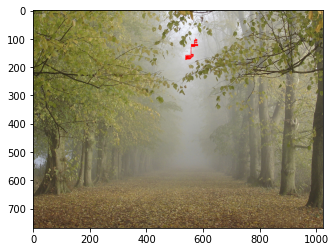

Atmospheric light is:  [217.84351145 219.08524173 225.96437659]


In [8]:
Atmospheric_light,brightest_pixels=get_Atmospheric_light(matrice_image, dark_channel,0.1,method='Mean')
a=matrice_image.copy()
a[brightest_pixels]=[255,0,0]
plt.imshow(a)
plt.show()

print("Atmospheric light is: ",Atmospheric_light)

##  **Estimating the Transmission**





<p>Après l’approximation de la lumière atmosphérique A, on va calculer maintenant la transmission $t$. Une hypothèse qu’on va utiliser dans les calculs suivants est que la transmission est constante dans chaque patch $\Omega(x)$. On notera la transmission du patch par $\tilde{t}(x)$. <br>
Appliquons l’opérateur minimum sur le patch local de l’image I : <br>
</p>
<br>
\begin{equation}
\min\limits_{y \in \Omega(x)}(I^c(y)= \tilde{t}(x)  \min\limits_{y \in \Omega(x)} (J^c(y)) + (1-\tilde{t}(x)) A^c
\end{equation}
<br>
<p>
L'opérateur minimum est appliqué aux 3 couleurs indépendamment :
</p>
<br>
\begin{equation}
\min\limits_{c}(\min\limits_{y \in \Omega(x)}(\frac{I^c(y)}{A^c})= \tilde{t}(x)  
\end{equation}
<br>
\begin{equation}
\min\limits_{c} (\min\limits_{y \in \Omega(x)} (\frac{J^c(y)}{A^c}) + (1-\tilde{t}(x))
\end{equation}
<br>
<p>
Selon la définition du dark channel, $J^{dark}$ pour une radiance $J$ qui ne contient pas du haze donne $J^{dark}$ = 0, et comme $A^c$ est toujours positive alors on aura:
</p>
<br>
\begin{equation}
\min\limits_{c}(\min\limits_{y \in \Omega(x)}(\frac{J^c(y)}{A^c})= 0
\end{equation}
<br><p>
Alors, l'equation de l'estimation de l'approximation sera:<br>
</p>
\begin{equation}
\tilde{t}(x) = 1-\min\limits_{c} (\min\limits_{y \in \Omega(x)} (\frac{I^c(y)}{A^c}))
\end{equation}
<p> Or, $\min\limits_{c} (\min\limits_{y \in \Omega(x)} (\frac{I^c(y)}{A^c}))$ represente le dark channel de l'image du haze normaliser.
Comme on a indiquer avant, le dark channel n'est pas efficace avec les regions contenant le ciel. Mais comme la couleur du ciel semble generallement a la lumiere atmospherique, alors $\tilde{t}$ tend vers 0 et parsuite l'equation precedente gere les regions contenant le ciel.</p>
<p>
En pratique, même dans de bonnes conditions de météo, l’atmosphère contiendra des petites particules et par suite on aura encore du haze spécifiquement pour les objets situant à une grande distance. En plus, la présence du haze est essentiel pour la vision des êtres humains pour percevoir la profondeur dans les images, alors, si on enlève tout le haze cela va faire l’image apparaître non naturel et la profondeur dans l’image sera perdu.<br>
Pour cela on fixera un pourcentage $\omega$% qui représentera la quantité du haze qu’on va retenir dans l’image pour les objets situé à une grande distance pour que l’image reste aperçue comme une image naturelle.<br>
L'estimation de la fonction du transmission $\tilde{t}(x)$ est :<br><br>
</p>
\begin{equation}
\boxed{\tilde{t}(x) = 1- \omega \min\limits_{c \in \{r,g,b\}}(\min\limits_{y \in \Omega(x)}(\frac{I^c(y)}{A^c})),}
\end{equation}
<br>
<p>
A l’aide de cette équation, on obtiendra ainsi l’estimation $\tilde{t}(x)$ de la transmission. Mais, on peut voir que le résultat contient un problème dues aux effets des blocks causer du faite qu’on a pris l’hypothèse que la transmission est constante dans chaque patch, ce qui n’est pas correcte dans la plupart des cas. 
</p>
 


In [9]:
def get_transmission_estimation(matrice_image,dark_channel,Atmospheric_light,perc_rem_haze):
  t=np.zeros(matrice_image.shape)
  for i in range(3):
    t[:,:,i] = 1-perc_rem_haze*dark_channel/Atmospheric_light[i]
  return t

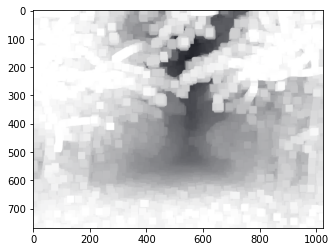

In [10]:
t=get_transmission_estimation(matrice_image,dark_channel,Atmospheric_light,0.95)
plt.imshow(t)
plt.show()

## **Filtrage Guidée**

<p>Comme indiquer dans la partie précédente le résultat contient des effets de blocks. Pour corriger le résultat on utilisera un filtre guidé. En effet, dans l’article, ils ont proposé d’utiliser la méthode du soft matting, mais cette méthode est très couteuse et prendra un grand temps d’exécution (à peu près 2 minutes), alors que si on adopte la méthode du filtre guidée on obtiendra un résultat très proche que celui du soft matting mais dans un temps beaucoup plus court (à peu près 0.3 secondes). <br>
Le filtre guidé est un filtre qui atténue le bruit tout en conservant les arêtes brusques. Ce filtre fonctionne comme le filtre bilatéral (filtre qui préserve les arrêts) mais en surmontant les problèmes du filtre bilatéral (complexité et distorsion du gradient). En effet, le filtre bilatéral a une complexité de calcul très élevée, alors que le filtre guidé n'utilise pas de calculs mathématiques trop compliqués dont leur complexité de calcul est linéaire. De plus, en raison du modèle mathématique, les filtres bilatéraux ont parfois des artefacts d'inversion de gradient indésirables et provoquent une distorsion de l'image. Alors que le filtre guidé, étant donné qu’il est mathématiquement basé sur une combinaison linéaire, l'image de sortie doit être cohérente avec la direction du gradient de l'image de guidage, et le problème d'inversion de gradient ne se produit pas.<br>
Pour expliquer mieux le fonctionnement, on décrira l’algorithme de ce filtre :<br>
On prend comme entrée du filtre le dark channel déjà calculer, et on utilise l’image de départ comme guide pour le filtre.<br>
</p>
${\displaystyle P}$: entree p <br>
${\displaystyle I}$: guide I <br>
${\displaystyle r}$: Rayon du fenetre <br>
${\displaystyle \epsilon }$: regularization  <br>
${\displaystyle q}$:  filtering output <br>
1. ${\displaystyle mean_{I}} =  {\displaystyle f_{mean}(I)} \\ \\
{\displaystyle mean_{p}} = {\displaystyle f_{mean}(p)} \\ \\
{\displaystyle corr_{I}} =   {\displaystyle f_{mean}(I.*I)}\\ \\
{\displaystyle corr_{Ip}} = {\displaystyle f_{mean}(I.*p)} \\ \\
$ <br>
2. 
$
{\displaystyle var_{I}} = {\displaystyle corr_{I}-mean_{I.}*mean_{I}} \\ \\
{\displaystyle cov_{Ip}} = {\displaystyle corr_{Ip}-mean_{I.}*mean_{p}} \\ \\
$
<br>
3. 
$
{\displaystyle a} = {\displaystyle cov_{Ip}./(var_{I}+\epsilon )} \\ \\
{\displaystyle b} = {\displaystyle mean_{p}-a.*mean_{I}} \\ \\
$
<br>
4. 
$
{\displaystyle mean_{a}} = {\displaystyle f_{mean}(a)} \\ \\
{\displaystyle mean_{b}} = {\displaystyle f_{mean}(b)} \\ \\
$
<br>
5. 
$
{\displaystyle mean_{q}} = {\displaystyle mean_{a.}*I+mean_{b}}
$
<br>
<p><b> Implementation: </p></b>
<br>
$
(1)　　{\displaystyle q_{i}=a_{k}I_{i}+b_{k},\forall i\in \omega _{k}} \\ \\
(2)　　{\displaystyle q_{i}=p_{i}-n_{i}}
$
<br>
Dans la formule ci-dessus:
<br>
${\displaystyle q_{i}}:$ est le ${\displaystyle i_{eme}}$ pixel de sortie; <br>
${\displaystyle p_{i}}:$ est le ${\displaystyle i_{eme}}$ pixel d'entree;; <br>
${\displaystyle n_{i}}:$ est le ${\displaystyle i_{eme}}$ pixel du bruit; <br>
${\displaystyle I_{i}}:$ est le ${\displaystyle i_{eme}}$ pixel de l'image de guide; <br>
${\displaystyle (a_{k},b_{k})}:$ sont des coefficients lineares supposes constants dans ${\displaystyle \omega _{k}}.$ <br>

La substraction de (1) et (2) donne la formule (3)；<br>
En meme temps, definir la fonction de cout (4)：<br>
$
(3)　　{\displaystyle n_{i}=p_{i}-a_{k}I_{i}-b_{k}}
 \\ \\
(4)　　{\displaystyle E(a_{k},b_{k})=\sum _{i{\epsilon }{\omega }_{k}}^{}((a_{k}I_{i}+b_{k}-p{i})^{2}+{\epsilon }a_{k}^{2})}
$
<br>
Dans la formule ci-dessus: <br>
${\displaystyle \epsilon }$ est le parametre de regularization ${\displaystyle a_{k}}$; <br>
${\displaystyle \omega _{k}}$ est un fenetre centree au pixel ${\displaystyle k}$. <br>
Et la solution de la fonction de cout est donnee par： <br>
$
(5)　　{\displaystyle a_{k}={\frac {{\frac {1}{\left|\omega \right|}}\sum _{i\epsilon \omega _{k}}I_{i}p_{i}-\mu _{k}{\bar {p_{k}}}}{\sigma _{k}^{2}+\epsilon }}}
 \\ \\
(6)　　{\displaystyle b_{k}={\bar {p_{k}}}-a_{k}\mu _{k}}
$
<br> <br>
Dans la formule ci-dessus:<br>
$
{\displaystyle \mu _{k}}$ and ${\displaystyle \sigma _{k}^{2}}$ sont la moyenne et la variance de ${\displaystyle I}$ dans ${\displaystyle \omega _{k}}
$ <br>
${\displaystyle \left|\omega \right|}$ le nombre de pixels dans ${\displaystyle \omega _{k}};$ <br>
${\displaystyle {\bar {p}}={\frac {1}{\left|\omega \right|}}\sum _{i\epsilon \omega _{k}}p_{i}}$ est la moyenne de ${\displaystyle p}$ dans ${\displaystyle \omega _{k}}$. <br>
Apres l'obtention des coefficients lineaires ${\displaystyle (a_{k},b_{k})}$, on peut calculer la sortie ${\displaystyle q_{i}}$ en utilisant l'equation (1).


In [11]:
import numpy as np
import scipy as sp
import scipy.ndimage
def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)
    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


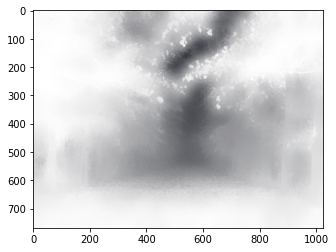

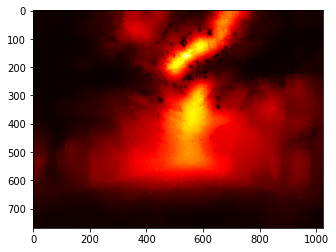

In [12]:
guided_trans = guidedFilter(matrice_image,(t*255).astype(np.uint8),25,0.05)
plt.imshow(guided_trans,cmap='gray')
plt.show()

plt.imshow(np.mean(-np.log2(guided_trans/255),axis=2),cmap='hot')
plt.show()

## **Recovering the Scene Radiance**




<p>D’après l’équation 1, on peut restaurer la radiance de la scène J(x).</p>


\begin{equation}
\boxed{
  J(x)=\frac{I(x) - A}{\max(t(x) , t_0)} + A
}
\end{equation}

<p>La valeur de J(x).t(x) peut être très proche de zéro lorsque la transmission possède des valeurs à peu près nulles et par suite le résultat sera bruité. Pour cela, on fixera une valeur t0 comme étant une borne inferieure pour les valeurs de la transmission peuvent prendre. Cette restriction va causer que les pixels dont la transmission est plus petite que t0 ne seront pas affecter par suite le haze sera préserver dans les régions qui ont du haze dense. La calibration de t0 doit être de façon à laisser les objets dont la couleur est proche de celle de la lumière atmosphérique (ex : le ciel) et restaurer la couleur des objets affectes par la lumière atmosphérique. Pour mieux comprendre cet effet on va faire varier t0 dans quelques images. </P>

In [13]:
def recoverSceneRadiance(img, atmosphericLight, transmission,t0):
  a=img.copy().astype(float)
  for i in range(3):
    a[:,:,i] = (img[:,:,i] - atmosphericLight[i])/np.fmax(transmission[:,:,i]/255,t0) + atmosphericLight[i]
  return a.astype(int)

## Effets des parametres 

In [17]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# load image
image_avec_haze="forest1.jpg"
im = Image.open(image_avec_haze)
matrice_image = np.asarray(im)

kernel_size = widgets.IntSlider(min=1, max=100, description='Kernel Size:', step=4, value=15,continuous_update=False,)
percentage_atmospheric_light = widgets.FloatSlider(min=0, step=0.05 ,description='Brightest pixels:', max=1, value=0.1,continuous_update=False,)
method_atmospheric_light= widgets.RadioButtons(options=['Mean', 'Max'], value='Mean',description='Method:',disabled=False,)
Remaining_haze = widgets.FloatSlider(min=0.001, description='Rem Haze:', max=1, step=0.05, value=0.95,continuous_update=False,)
t0 = widgets.FloatSlider(min=0.001, description='t0:', max=1, step=0.05, value=0.1,continuous_update=False,)
GuidedFilter = widgets.Checkbox(
    value=False,
    description='Guided Filter',
    disabled=False,
    indent=False
)
filterBoxSizes = widgets.IntSlider(min=1, description='Kernel Size:', max=100, value=0,continuous_update=False,disabled=True)
epss = widgets.FloatSlider(min=0.001, step=0.05, max=1, value=0,continuous_update=False,disabled=True)

def update_plot(kernel_size, 
                percentage_atmospheric_light, 
                method_atmospheric_light,
                Remaining_haze,
                t0,
                GuidedFilter,
                filterBoxSize,
                eps):
  # calculate dark channel
  dark_channel = darkChannel(matrice_image,(kernel_size,kernel_size))
  # get atmosheric light
  Atmospheric_light,brightest_pixels = get_Atmospheric_light(matrice_image, dark_channel, percentage_atmospheric_light, method_atmospheric_light)
  # calculate transmission
  t = get_transmission_estimation(matrice_image,dark_channel,Atmospheric_light,perc_rem_haze=Remaining_haze)

  # Apply Guided filter on the transmission to minimize block effect
  if GuidedFilter:
    filterBoxSizes.disabled=False
    epss.disabled=False
    guided_trans = guidedFilter(matrice_image,(t*255).astype(np.uint8),filterBoxSize,eps)
  else: 
    guided_trans = (t*255).astype(np.uint8)
    filterBoxSize=1
    eps=0
    filterBoxSizes.disabled=True
    epss.disabled=True
  
  plt.figure(figsize=(8,8))
  plt.imshow(guided_trans,cmap='gray')
  plt.show()

  # recovering
  a = recoverSceneRadiance(matrice_image, Atmospheric_light, guided_trans, t0)
  # show result
  plt.figure(figsize=(8,8))
  plt.imshow(im)
  plt.show()
  plt.figure(figsize=(8,8))
  plt.imshow(a)
  plt.show()

widgets.interactive(update_plot, 
                    kernel_size=kernel_size,
                    percentage_atmospheric_light=percentage_atmospheric_light,
                    method_atmospheric_light=method_atmospheric_light,
                    Remaining_haze=Remaining_haze,
                    GuidedFilter=GuidedFilter,
                    t0=t0,
                    filterBoxSize=filterBoxSizes,
                    eps=epss)

interactive(children=(IntSlider(value=15, continuous_update=False, description='Kernel Size:', min=1, step=4),…